# Анализ объявлений на Airbnb в Лондоне 🇬🇧

## импортируем нужные библиотеки

In [47]:
import pandahouse as ph
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## объявляем параметры подключения

In [5]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

### Шаг 2
### Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: вывеcnb количество строк в таблице ldn_listings.

In [8]:
query = """
SELECT 
    count() AS rows
FROM 
    default.ldn_listings
"""
ldn_listings = ph.read_clickhouse(query, connection=connection)
ldn_listings.rows.iloc[0]

85207

### Шаг 3
### Выгрузим из таблицы данные о цене жилья и вычислим 70-й квантиль цены для каждого типа жилья

In [10]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM
    default.ldn_listings
ORDER BY
    id ASC
LIMIT 1000
"""
room_type_price = ph.read_clickhouse(query, connection=connection)
room_type_price.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [11]:
quantile_price = room_type_price.groupby('room_type') \
    .price.quantile(0.75)
quantile_price

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

In [12]:
quantile_price['Private room']

70.0

### Шаг 4
### К данным о цене и типе комнаты выгрузим данные о рейтинге жилья (review_scores_rating), отфильтруем пустые значения review_scores_rating и сконвертируем эту колонку в тип float32.

###  Дополнительно построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [13]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating_
FROM
    default.ldn_listings
WHERE
    review_scores_rating_ > 0
ORDER BY
    id ASC
LIMIT 1000
"""
df_4 = ph.read_clickhouse(query, connection=connection)
df_4.head()

,room_type,price_,review_scores_rating_
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [22]:
df_4_agg = df_4.groupby(['room_type'], as_index=False) \
    .agg({'price_' : 'mean',
          'review_scores_rating_' : 'mean'}) \
    .rename(columns={'price_' : 'avg_price', 'review_scores_rating_' : 'avg_rating'}) 

df_4_agg

,room_type,avg_price,avg_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


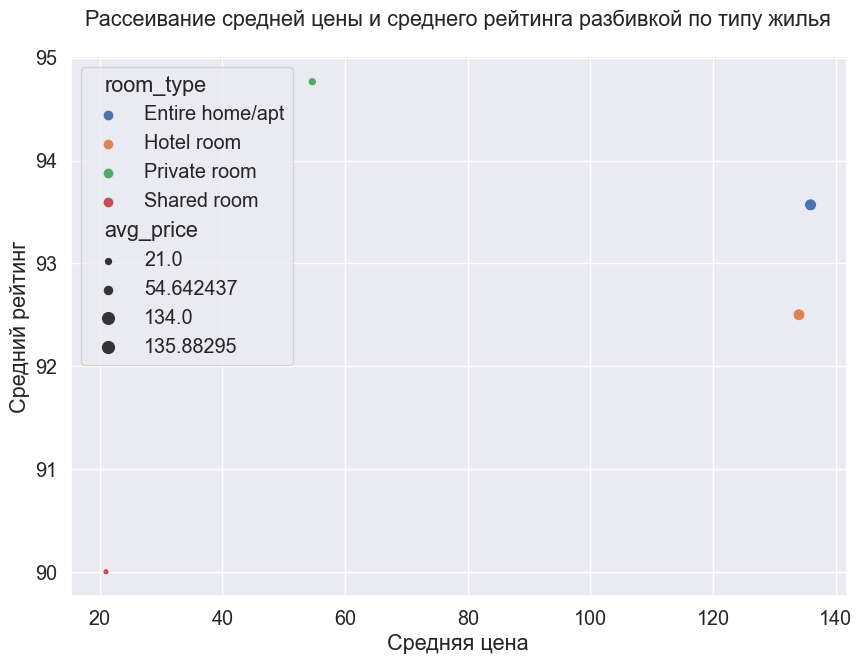

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale =1.3)

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_4_agg, x="avg_price", y="avg_rating", hue="room_type", ax=ax, size="avg_price")

ax.set_ylabel('Средний рейтинг')
ax.set_xlabel('Средняя цена')
ax.set_title('Рассеивание средней цены и среднего рейтинга разбивкой по типу жилья\n')
sns.despine()

### Шаг 5
### Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

### Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

* host_id – идентификатор хозяина (уникальный)
* host_verifications – какими способами хост подтвердил свой профиль

### Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [26]:
query = """
SELECT
    DISTINCT host_id AS unique_host_id,
    host_verifications
FROM
    default.ldn_listings
WHERE
    experiences_offered != 'none'
"""
df_5 = ph.read_clickhouse(query, connection=connection)
df_5

,unique_host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [27]:
df_5['host_verifications'] = df_5['host_verifications'].apply(lambda x: x.strip('[]').replace("'",'').split(', '))

In [28]:
answer_5 = df_5.host_verifications.explode().value_counts()
answer_5

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

Вариант 2 финальной строки. Он более лаконичный и больше подходит для pd.Series

In [30]:
answer_5['google']

34

### Шаг 6
### Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления% cгруппируем данные по району и виду впечатления, а также посчитаем количество объявлений.

In [32]:
query = """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    Count(id) AS experiences_count
FROM
    default.ldn_listings
WHERE
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
"""
df_6 = ph.read_clickhouse(query, connection=connection)
df_6.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [33]:
df_6_pivot = df_6 \
    .pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

df_6_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


Text(0.5, 1.0, 'Распределение типов мероприятий по районам Лондона\n')

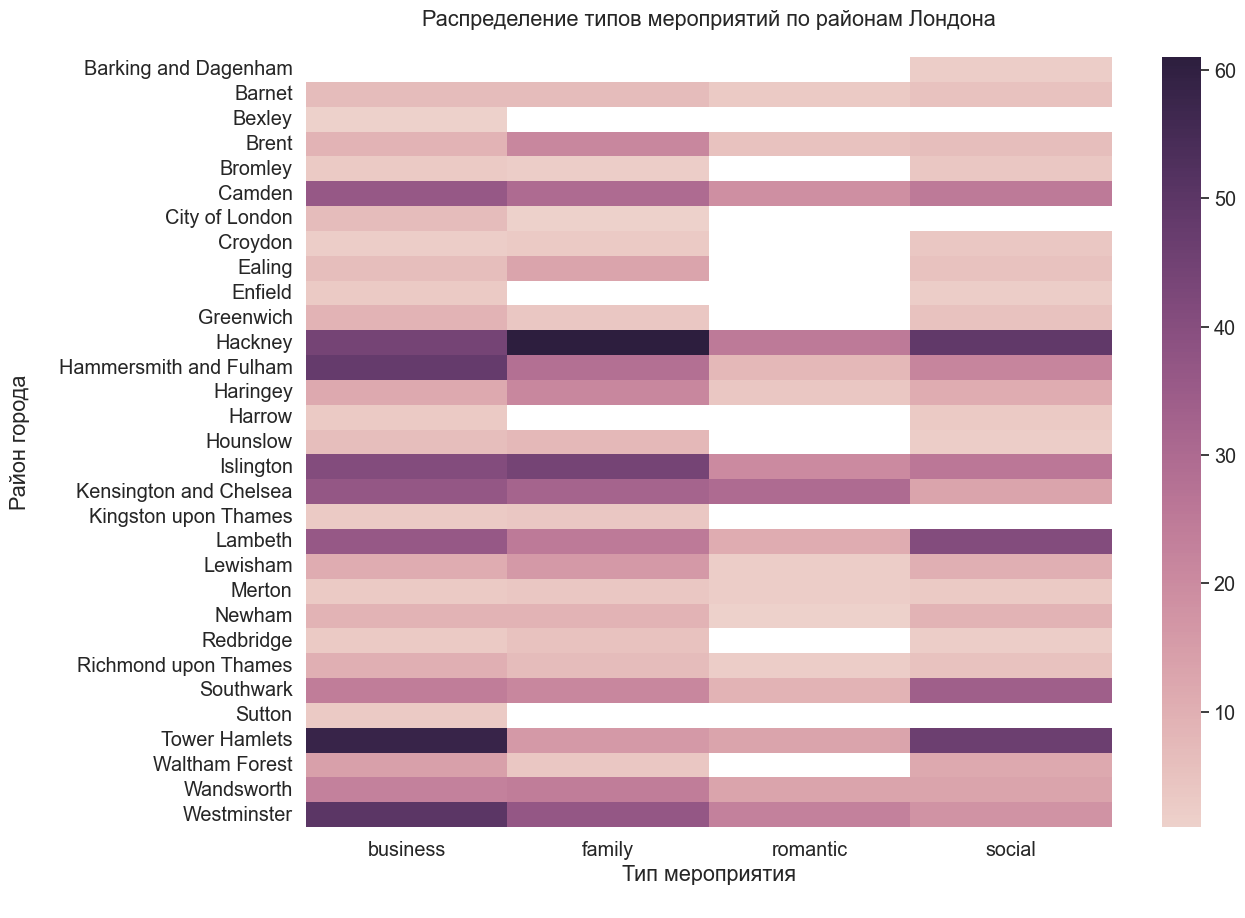

In [42]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(df_6_pivot, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

sns.set_style("white")

ax.set_ylabel('Район города\n')
ax.set_xlabel('Тип мероприятия\n')
ax.set_title('Распределение типов мероприятий по районам Лондона\n')

### Шаг 7
### Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые нам для составления запроса столбцы:

* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* price – цена за ночь 
* experiences_offered – вид доступного впечатления (оставить не 'none')

In [44]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM
    default.ldn_listings
WHERE
    experiences_offered != 'none'
"""
df_7 = ph.read_clickhouse(query, connection=connection)
df_7.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


Далее пострим два графика, используя distplot из библиотеки seaborn:

На первом отобразим исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

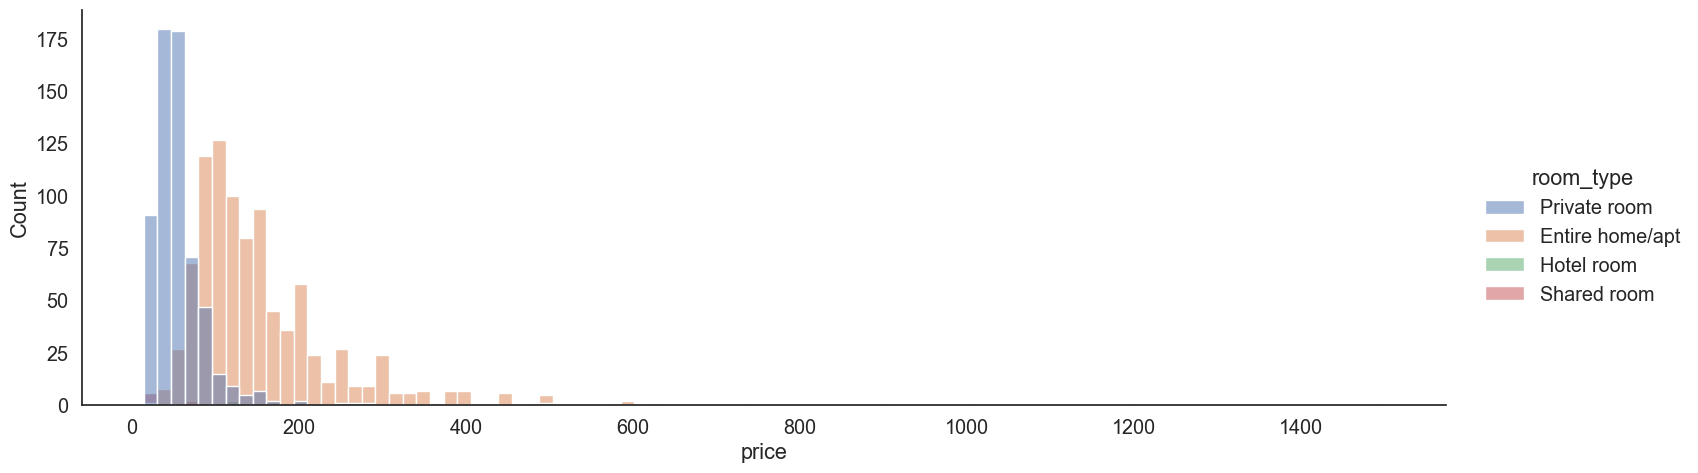

In [45]:
import numpy as np
sns.displot(data=df_7, x='price', hue='room_type', height=5, aspect=3)
sns.despine()

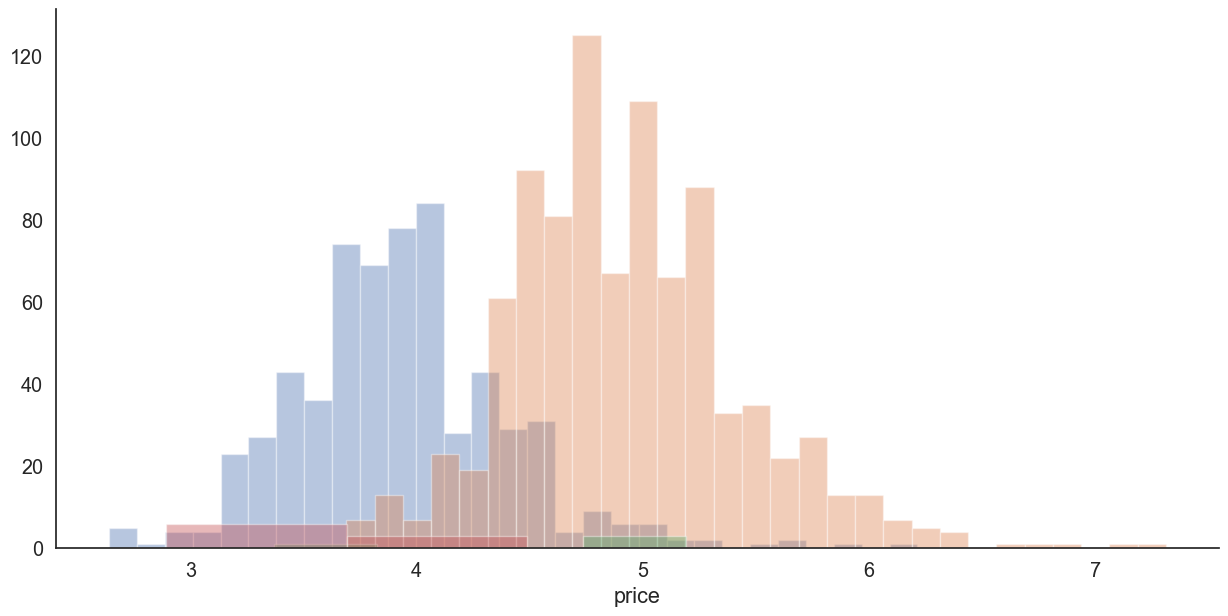

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(np.log(df_7.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_7.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_7.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_7.query("room_type=='Shared room'").price), kde=False, label='Shared room')
sns.despine()

Более удачный вариант решения с множеством графиков на одном полотне

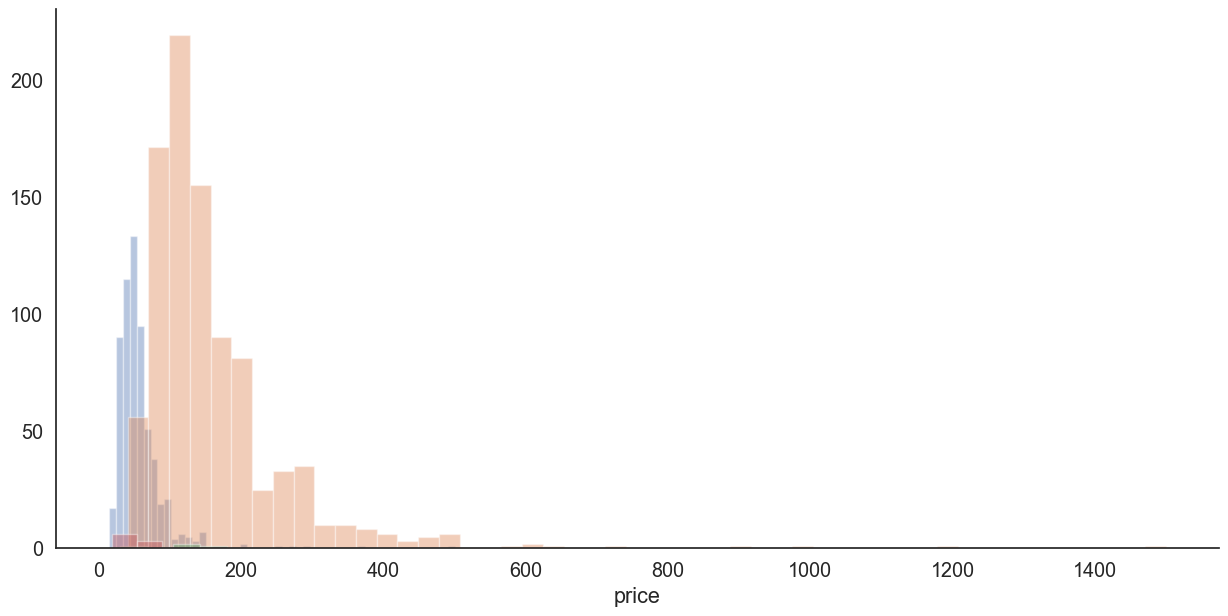

In [53]:
fig, ax = plt.subplots(figsize=(15,7))
for room in df_7.room_type.unique():
    sns.distplot((df_7.loc[df_7.room_type == room].price), kde=False, label = room)
sns.despine()

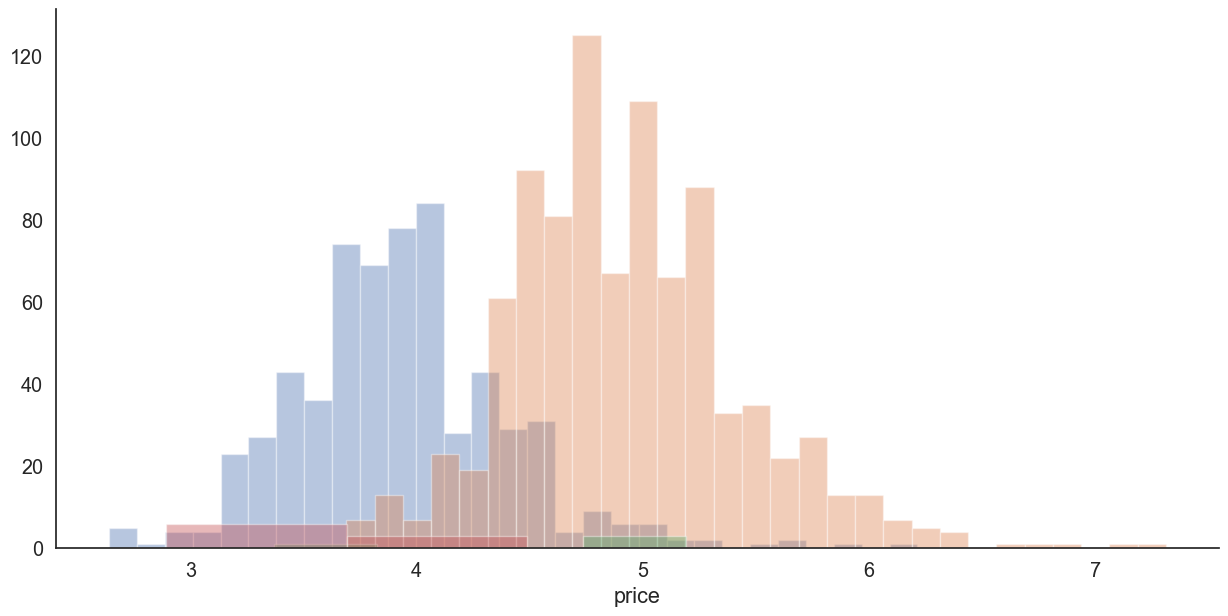

In [54]:
fig, ax = plt.subplots(figsize=(15,7))


for room in df_7.room_type.unique():
    sns.distplot(np.log(df_7.loc[df_7.room_type == room].price), kde=False, label = room)
sns.despine()

### Шаг 8
### Выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые для этого столбцы:

* room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* price – цена за ночь
* first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

Ограничение на запрос: 1000 строк.

In [59]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toYear((toDateOrNull(first_review))) AS first_review_year
FROM
    default.ldn_listings
WHERE
    first_review > '2010-01-01'
LIMIT 1000
"""
df_8 = ph.read_clickhouse(query, connection=connection)
df_8.sort_values("first_review_year").head()

,room_type,price,first_review_year
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010


Используя библиотеку seaborn и функцию lineplot, построим график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

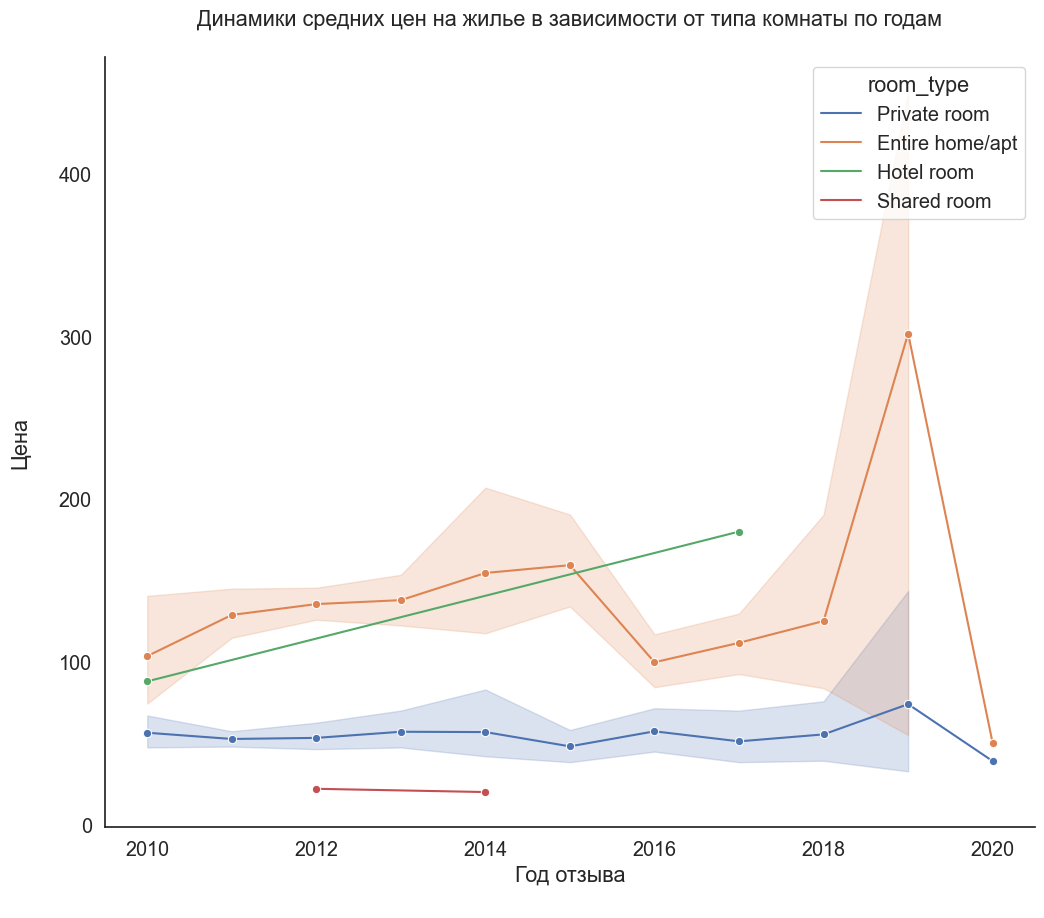

In [60]:
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x='first_review_year', y='price', data=df_8, marker='o', hue = 'room_type')

ax.set_ylabel('Цена\n')
ax.set_xlabel('Год отзыва\n')
ax.set_title('Динамики средних цен на жилье в зависимости от типа комнаты по годам\n')
sns.despine()  # убрать часть рамки графика
plt.show()